# Face Identification Classifier

### Ref https://github.com/peteryuX/arcface-tf2

In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from models import ArcFaceModel
# from losses import SoftmaxLoss
from losses import softmax_loss
import dataset
import tensorflow as tf
import os
import logging

tf.get_logger().setLevel(logging.ERROR)
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
!echo $CUDA_VISIBLE_DEVICES

0


In [4]:
### IJB-C Dataset

# batch_size = 128
# input_size = 112
# embd_shape = 512
# head_type = 'ArcHead'
# backbone_type = 'MobileNetV2'
# w_decay=5e-4
# num_classes = 3584 
# base_lr = 0.01
# dataset_len = 13033 
# epochs = 100
# steps_per_epoch = dataset_len // batch_size

### MS1M dataset

batch_size = 128 # Initially 128
input_size = 112
embd_shape = 512
head_type = 'ArcHead'
backbone_type = 'MobileNetV2'
w_decay=5e-4
num_classes = 85742 
dataset_len = 5822653 
base_lr = 0.01 # initially 0.01
epochs = 20
save_steps = 1000
steps_per_epoch = dataset_len // batch_size
steps = 1
is_ccrop=False
binary_img=True
is_Adam = False

### Find latest checkpoint

In [5]:
from glob import glob
base_dir = "/hd/jbpark/models/checkpoints/wo_tfidentity/"
save_name = "e*"
file_list = []
for files in glob(base_dir+save_name):
    file_list.append(files.split('/')[-1].split('l_')[-1])
file_list.sort()

load_file_name = []
for files in glob(base_dir+save_name):
    if file_list[0] == files.split('/')[-1].split('l_')[-1]:
        load_file_name = files
best_checkpoint = load_file_name.split('.data')[0]
best_checkpoint

'/hd/jbpark/models/checkpoints/wo_tfidentity/e_5_l_16.65623664855957.ckpt'

# Training Face Identification Classifier

In [6]:
import numpy as np
import tensorflow as tf
from pathlib import Path
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from layers import ArcMarginPenaltyLogists
from losses import softmax_loss
from models import ArcFaceModel
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

weight_file = best_checkpoint

model = ArcFaceModel(size=input_size,
                         backbone_type=backbone_type,
                         training=False)
model.load_weights(weight_file)
model.summary()

Model: "arcface_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 112, 112, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
OutputLayer (Functional)     (None, 512)               10493440  
Total params: 12,751,424
Trainable params: 12,713,728
Non-trainable params: 37,696
_________________________________________________________________


### Extract Embedding Vectors & Create Classifier Training Dataset

In [ ]:
import cv2
import numpy as np
from utils import l2_norm
from glob import glob
from tqdm import tqdm

dataset_path = "/hd/jbpark/dataset/IJB-C_Asian/Aligned/"

In [32]:
import os 
from tqdm import tqdm
id_list = os.listdir(dataset_path)
id_list.sort()
source_id = []
for id_name in tqdm(id_list):
    source_id.append(int(id_list.index(id_name)))
len(np.unique(np.array(source_id)))

100%|██████████| 3584/3584 [00:00<00:00, 66627.60it/s]


3584

In [43]:
subjects = id_list
label_int = source_id
embed_list = []
label_list = []
for subject in tqdm(subjects):
#     print("[*] Encode {} to Embedding Vector ({})".format(subject,embd_shape))
    img_paths = glob(dataset_path+subject+"/*")
    for img_path in img_paths:
#         print("[*] Encode {} to ./output_embeds.npy".format(img))
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (112,112))
        img = img.astype(np.float32) / 255.
        # print("len(img.shape): "+str(len(img.shape))+ ", img.shape = "+str(img.shape))
        if len(img.shape) == 3:
            img = np.expand_dims(img, 0)

    #     print("len(img.shape): "+str(len(img.shape))+ ", img.shape = "+str(img.shape))
        embeds = l2_norm(model(img, training=False))
    #     embeds.shape
    #     embeds
        embed_list.append(embeds[0].numpy())
        label_list.append(label_int[subjects.index(subject)])
embed_list = np.asarray(embed_list)
label_list = np.asarray(label_list)
# embed_list

100%|██████████| 3584/3584 [05:57<00:00, 10.02it/s]


In [44]:
save_path = "/hd/jbpark/IJB-C_Asian/"
np.save(save_path+'ijbc_embed_vectors.npy', embed_list)
np.save(save_path+'ijbc_labels.npy', label_list)

### Create Face Identification Classifer with Centroid Vector

In [28]:
import numpy as np
import os 
from tqdm import tqdm

save_path = "/hd/jbpark/dataset/IJB-C_Asian/"
embed_list = np.load(save_path+'ijbc_embed_vectors.npy')
label_list = np.load(save_path+'ijbc_labels.npy')

dataset_path = "/hd/jbpark/dataset/IJB-C_Asian/Aligned/"
id_list = os.listdir(dataset_path)
id_list.sort()

unique_labels = np.unique(label_list)

centroid_list = []
for i in tqdm(unique_labels):
    temp_list = np.where(label_list==i)[0]
    centroid = np.average(embed_list[temp_list],axis=0)
    centroid_list.append(centroid)
np.array(centroid_list).shape

100%|██████████| 3584/3584 [00:00<00:00, 48223.07it/s]


(3584, 512)

In [18]:
id_list

['2 Chainz',
 '50 Cent',
 'A. P. J. Abdul Kalam',
 'A.K. Antony',
 'AF0301',
 'AF0302',
 'AF0303',
 'AF0304',
 'AF0305',
 'AF0306',
 'AF0307',
 'AF0308',
 'AF0309',
 'AF0310',
 'AF0311',
 'AF0312',
 'AF0313',
 'AF0314',
 'AF0315',
 'AF0316',
 'AF0317',
 'AF0318',
 'AF0319',
 'AF0320',
 'AF0321',
 'AF0322',
 'AF0323',
 'AF0325',
 'AF0326',
 'AF0327',
 'AF0328',
 'AF0329',
 'AF0330',
 'AF0331',
 'AF0332',
 'AF0333',
 'AF0334',
 'AF0336',
 'AJ Lee',
 'AM0301',
 'AM0302',
 'AM0303',
 'AM0304',
 'AM0305',
 'AM0306',
 'AM0307',
 'AM0308',
 'AM0309',
 'AM0310',
 'AM0311',
 'AM0312',
 'AM0313',
 'AM0314',
 'AM0315',
 'AM0316',
 'AM0317',
 'AM0318',
 'AM0319',
 'Aaron Paul',
 'Aaron Sorkin',
 'Abbas Kiarostami',
 'Abby Wambach',
 'Abdallah Djaballah',
 'Abdel Fattah el-Sisi',
 'Abdelilah Benkirane',
 'Abdellah Taïa',
 'Abdelmalek Sellal',
 'Abderrahmane Sissako',
 'Abdou Diouf',
 'Abdoulaye Wade',
 'Abdul Jabbar',
 'Abdul Malik Baloch',
 'Abdullah Abdullah',
 'Abdullah Bin Zayed al-Nahyan',
 'A

In [31]:
np.savetxt('/hd/jbpark/dataset/numpy/id_list.txt', id_list, fmt='%s', delimiter=',')
np.savetxt('/hd/jbpark/dataset/numpy/centroid_list.csv', centroid_list, fmt='%f', delimiter=',')

### Test on Image with Euclidean Distance

##### Testing with the image out of Test Gallery

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


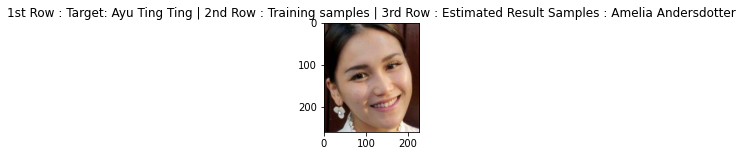

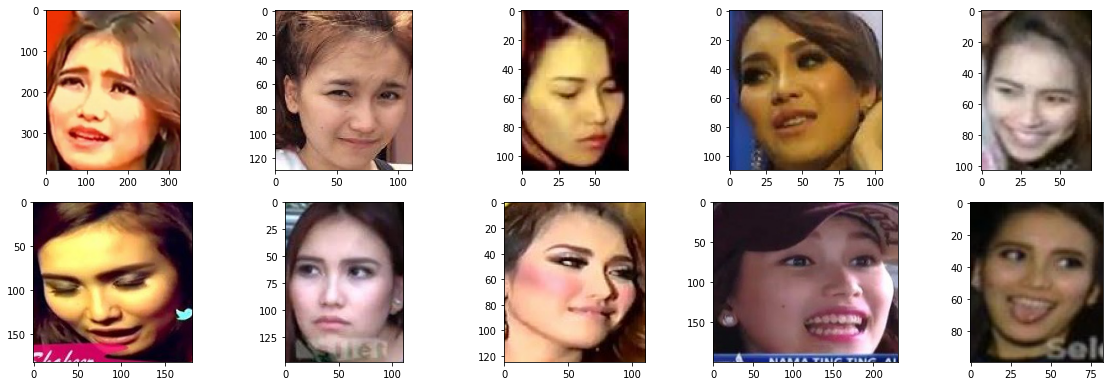

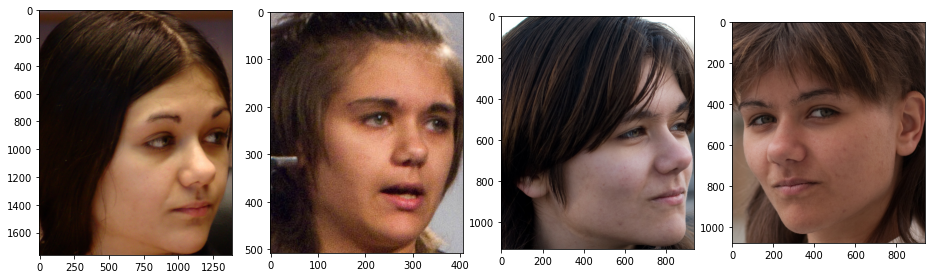

In [10]:
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from utils import l2_norm
%matplotlib inline

# org_img_path = 'Test/Kelly Clarkson.jpg'
# org_img_path = 'Test/Baby Margaretha.jpg' # Good
# org_img_path = 'Test/Gareth Bale.jpg' 
# org_img_path = 'Test/Kelly Holmes.jpg'
# org_img_path = 'Test/Daniele Suzuki.jpg'
org_img_path = 'Test/Ayu Ting Ting.jpg'

img = cv2.imread(org_img_path)
convert_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.resize(convert_img, (112,112))
img = img.astype(np.float32) / 255.

if len(img.shape) == 3:
    img = np.expand_dims(img, 0)

#     print("len(img.shape): "+str(len(img.shape))+ ", img.shape = "+str(img.shape))
embeds = l2_norm(model(img, training=False))
distance_list=[]
for centroid in centroid_list:
    distance_list.append(np.linalg.norm(embeds-centroid))

# Rank 1
    
# print(np.argmin(distance_list))
# print(np.min(distance_list))

target = id_list[np.argmin(distance_list)]

plt.figure(figsize=(4,2))
plt.title("1st Row : Target: "+org_img_path.split('/')[-1].split('.')[0] +" | 2nd Row : Training samples"+ " | 3rd Row : Estimated Result Samples : "+target)
plt.imshow(convert_img)

dir_base = "/hd/jbpark/dataset/IJB-C_Asian/Aligned/"
img_dirs = glob(dir_base+org_img_path.split('/')[-1].split('.')[0]+"/*")

images = []
for img_path in img_dirs:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    
dir_base = "/hd/jbpark/dataset/IJB-C_Asian/Aligned/"
img_dirs = glob(dir_base+target+"/*")

images = []
for img_path in img_dirs:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

##### Testing with Closed-set

In [62]:
distance_list = []
correct_sum=0
for index,i in tqdm(enumerate(embed_list)):
    distance_list = []
    for centroid in centroid_list:
        distance_list.append(np.linalg.norm(i-centroid))
    if id_list[label_list[index]] == id_list[np.argmin(distance_list)]:
        correct_sum+=1
#         print("True")
#     else:
#         print(id_list[label_list[index]])
#         print(id_list[np.argmin(distance_list)])
#         print("False")
print("Score: "+str(correct_sum/len(embed_list)))

13033it [03:47, 57.25it/s]

Score: 0.8099439883372976


### Rank N

In [19]:
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from utils import l2_norm    
import pandas as pd
%matplotlib inline

Rank = 5

# org_img_path = 'Test/Kelly Clarkson.jpg'
# org_img_path = 'Test/Baby Margaretha.jpg' # Good
# org_img_path = 'Test/Gareth Bale.jpg' 
# org_img_path = 'Test/Kelly Holmes.jpg'
# org_img_path = 'Test/Daniele Suzuki.jpg'
org_img_path = 'Test/Ayu Ting Ting.jpg'

img = cv2.imread(org_img_path)
convert_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.resize(convert_img, (112,112))
img = img.astype(np.float32) / 255.

if len(img.shape) == 3:
    img = np.expand_dims(img, 0)

#     print("len(img.shape): "+str(len(img.shape))+ ", img.shape = "+str(img.shape))
embeds = l2_norm(model(img, training=False))
distance_list=[]
for centroid in centroid_list:
    distance_list.append(np.linalg.norm(embeds-centroid))


df = pd.DataFrame(distance_list)
sorted_df = df.sort_values(by=0)
estimated_label = np.asarray(sorted_df[:Rank].index)

id_list = np.array(id_list)
print(id_list[estimated_label])

['Amelia Andersdotter' 'Madison Chock' 'Tata Young' 'Ayu Ting Ting'
 'Renata Przemyk']


### Testing with Cosine Similarity

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


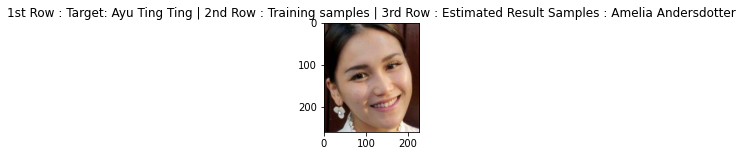

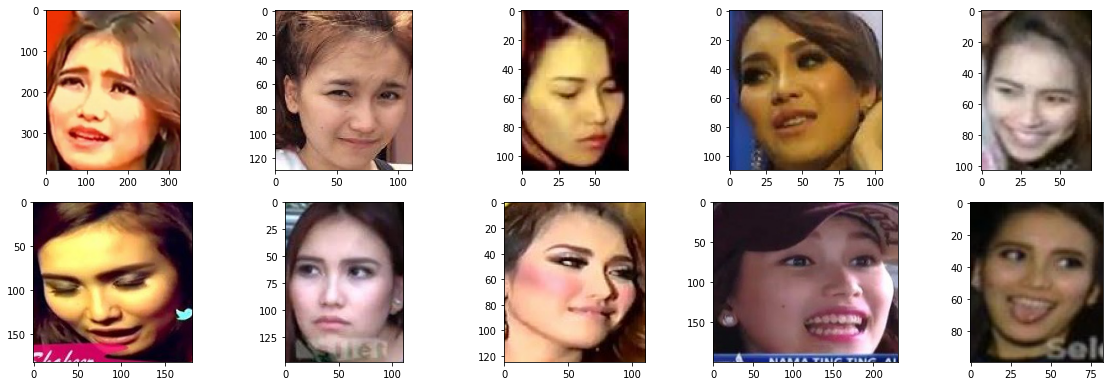

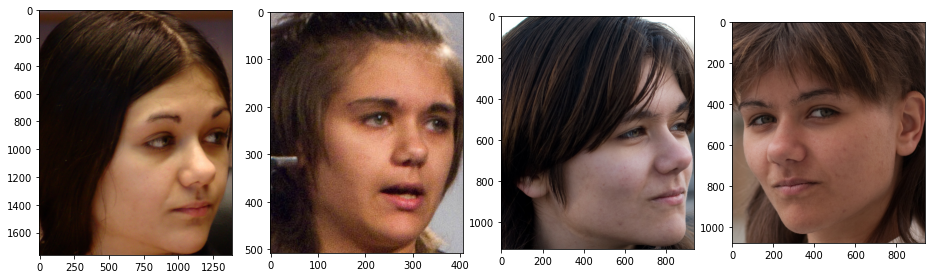

In [9]:
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from utils import l2_norm
%matplotlib inline

# org_img_path = 'Test/Kelly Clarkson.jpg'
# org_img_path = 'Test/Baby Margaretha.jpg' # Good
# org_img_path = 'Test/Gareth Bale.jpg' 
# org_img_path = 'Test/Kelly Holmes.jpg'
# org_img_path = 'Test/Daniele Suzuki.jpg'
org_img_path = 'Test/Ayu Ting Ting.jpg'

img = cv2.imread(org_img_path)
convert_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.resize(convert_img, (112,112))
img = img.astype(np.float32) / 255.

if len(img.shape) == 3:
    img = np.expand_dims(img, 0)

#     print("len(img.shape): "+str(len(img.shape))+ ", img.shape = "+str(img.shape))
embeds = l2_norm(model(img, training=False))
distance_list=[]
for centroid in centroid_list:
    distance_list.append(np.dot(embeds,centroid)/(np.linalg.norm(embeds)*np.linalg.norm(centroid)))

# Rank 1
    
# print(np.argmin(distance_list))
# print(np.min(distance_list))

target = id_list[np.argmax(distance_list)]

plt.figure(figsize=(4,2))
plt.title("1st Row : Target: "+org_img_path.split('/')[-1].split('.')[0] +" | 2nd Row : Training samples"+ " | 3rd Row : Estimated Result Samples : "+target)
plt.imshow(convert_img)

dir_base = "/hd/jbpark/dataset/IJB-C_Asian/Aligned/"
img_dirs = glob(dir_base+org_img_path.split('/')[-1].split('.')[0]+"/*")

images = []
for img_path in img_dirs:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    
dir_base = "/hd/jbpark/dataset/IJB-C_Asian/Aligned/"
img_dirs = glob(dir_base+target+"/*")

images = []
for img_path in img_dirs:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

##### Rank N

In [16]:
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from utils import l2_norm    
import pandas as pd
%matplotlib inline

Rank = 5

# org_img_path = 'Test/Kelly Clarkson.jpg'
# org_img_path = 'Test/Baby Margaretha.jpg' # Good
# org_img_path = 'Test/Gareth Bale.jpg' 
# org_img_path = 'Test/Kelly Holmes.jpg'
org_img_path = 'Test/Daniele Suzuki.jpg'
# org_img_path = 'Test/Ayu Ting Ting.jpg'

img = cv2.imread(org_img_path)
convert_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.resize(convert_img, (112,112))
img = img.astype(np.float32) / 255.

if len(img.shape) == 3:
    img = np.expand_dims(img, 0)

#     print("len(img.shape): "+str(len(img.shape))+ ", img.shape = "+str(img.shape))
embeds = l2_norm(model(img, training=False))
distance_list=[]
for centroid in centroid_list:
    distance_list.append(np.dot(embeds,centroid)/(np.linalg.norm(embeds)*np.linalg.norm(centroid)))


df = pd.DataFrame(distance_list)
sorted_df = df.sort_values(by=0,ascending=False)
estimated_label = np.asarray(sorted_df[:Rank].index)

id_list = np.array(id_list)
print(id_list[estimated_label])

['Nam Sang-mi' 'Kathryn Bernardo' 'Daniele Suzuki' 'Kristi Yamaguchi'
 'Ayumi Kurihara']
